# Instrument Statistics Calculation

## Overview
This notebook calculates key instrument statistics for financial time series data, specifically focusing on log returns. The metrics calculated provide insights into the distribution and volatility of financial returns over time. The following key metrics are computed:
- **Four Moments**: Mean, variance, skewness, and kurtosis, which provide a foundational description of the data's distribution.
- **EWMA (Exponentially Weighted Moving Average) Variance and MAD**: Time-sensitive metrics that emphasize recent observations, offering a more dynamic view of volatility.
- **AR(1) Coefficient**: A measure of the autocorrelation between consecutive log returns.
- **Anti-Procyclicality Variance**: A rolling measure of volatility that helps capture market behavior over time.
- **Student-t Distribution Fit**: Fit the data to a Student-t distribution to account for fat tails in the return distribution.
- **EWMA Higher-Order Moments**: Time-sensitive skewness and kurtosis, showing how the shape of the return distribution evolves.

These metrics will be saved to CSV for each financial instrument, and visualizations will be generated for log returns and their distribution.

## Why These Metrics?
- **Four Moments**: Provide a detailed picture of the underlying return distribution, which is crucial for understanding risk and return characteristics.
- **EWMA Variance and MAD**: Capture volatility while placing more weight on recent data, which is essential for making timely investment decisions.
- **AR(1) Coefficient**: Helps detect patterns in the time series data, indicating whether returns follow a predictable trend.
- **Student-t Distribution Fit**: Financial returns often exhibit fat tails and skewed distributions, making the Student-t distribution a better fit than normal distribution.


In [69]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os


In [70]:
def load_and_process_data(ticker):
    """
    Load the historical stock price data for the given ticker and calculate log returns.

    Parameters:
    ticker (str): The stock ticker symbol.

    Returns:
    pd.DataFrame: A DataFrame containing log returns for the ticker.
    """
    data = pd.read_csv(f'../data/processed/{ticker}_processed.csv', index_col='Date', parse_dates=True)

    # Calculate log returns from close to close
    data['Log_Return_Close_Close'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

    # Drop any NaN values from log returns
    data = data.dropna(subset=['Log_Return_Close_Close'])

    return data


In [71]:
def calculate_moments(log_returns):
    """
    Calculate the four moments (mean, variance, skewness, kurtosis) of the log returns.

    Parameters:
    log_returns (pd.Series): A series of log returns for a financial instrument.

    Returns:
    tuple: Mean, variance, skewness, and kurtosis of the log returns.
    """
    mean = log_returns.mean()
    variance = log_returns.var()
    skewness = log_returns.skew()
    kurtosis = log_returns.kurt()
    return mean, variance, skewness, kurtosis


In [72]:
def calculate_ewma_variance(log_returns, decay_factor=0.94):
    """
    Calculate the exponentially weighted moving average (EWMA) variance of the log returns.
    
    Parameters:
    log_returns (pd.Series): A series of log returns for a financial instrument.
    decay_factor (float): The decay factor for weighting recent data more heavily. Default is 0.94.
    
    Returns:
    pd.Series: The EWMA variance of the log returns over time.
    """
    return log_returns.ewm(span=(1 / (1 - decay_factor))).var()


In [73]:
def devolve_ewma_variance(ewma_variance):
    """
    Devolve the EWMA variance by adjusting for volatility (standard deviation).
    
    Parameters:
    ewma_variance (pd.Series): A series of EWMA variance values.
    
    Returns:
    pd.Series: The devolved EWMA variance (standard deviation).
    """
    return np.sqrt(ewma_variance)


In [74]:
def calculate_ewma_mad(log_returns, decay_factor=0.94):
    """
    Calculate the exponentially weighted moving average (EWMA) mean absolute deviation (MAD) of the log returns.
    
    Parameters:
    log_returns (pd.Series): A series of log returns for a financial instrument.
    decay_factor (float): The decay factor for weighting recent data more heavily. Default is 0.94.
    
    Returns:
    pd.Series: The EWMA MAD of the log returns over time.
    """
    mean = log_returns.ewm(span=(1 / (1 - decay_factor))).mean()
    mad = (log_returns - mean).abs().ewm(span=(1 / (1 - decay_factor))).mean()
    return mad


In [75]:
def devolve_ewma_mad(ewma_mad):
    """
    Devolve the EWMA MAD by adjusting for volatility.
    
    Parameters:
    ewma_mad (pd.Series): A series of EWMA MAD values.
    
    Returns:
    pd.Series: The devolved EWMA MAD (standard deviation).
    """
    return ewma_mad / np.sqrt(2)


In [76]:
def calculate_sample_mad(log_returns):
    """
    Calculate the sample mean absolute deviation (MAD) of the log returns.
    
    Parameters:
    log_returns (pd.Series): A series of log returns for a financial instrument.
    
    Returns:
    float: The sample MAD of the log returns.
    """
    mean = log_returns.mean()
    sample_mad = (log_returns - mean).abs().mean()
    return sample_mad


In [77]:
def calculate_ar1_coefficient(log_returns):
    """
    Calculate the AR(1) (Auto Regressive 1st order) coefficient for the log returns.
    
    Parameters:
    log_returns (pd.Series): A series of log returns for a financial instrument.
    
    Returns:
    float: The AR(1) coefficient.
    """
    return log_returns.autocorr(lag=1)


In [78]:
def calculate_anti_procyclicality_variance(log_returns, window=30):
    """
    Calculate the anti-procyclicality variance of the log returns, using a rolling window.
    
    Parameters:
    log_returns (pd.Series): A series of log returns for a financial instrument.
    window (int): The rolling window size. Default is 30 days.
    
    Returns:
    pd.Series: The rolling variance over the specified window.
    """
    return log_returns.rolling(window=window).var()


In [79]:
def fit_student_t_distribution(log_returns):
    """
    Fit a Student-t distribution to the log returns.
    
    Parameters:
    log_returns (pd.Series): A series of log returns for a financial instrument.
    
    Returns:
    tuple: Degrees of freedom, location, and scale parameters of the fitted Student-t distribution.
    """
    df, loc, scale = stats.t.fit(log_returns)
    return df, loc, scale


In [80]:
def ewma_skewness_kurtosis(log_returns, decay_factor=0.94):
    """
    Calculate the exponentially weighted moving average (EWMA) skewness and kurtosis of the log returns.
    
    Parameters:
    log_returns (pd.Series): A series of log returns for a financial instrument.
    decay_factor (float): The decay factor for weighting recent data more heavily. Default is 0.94.
    
    Returns:
    tuple: EWMA skewness and kurtosis.
    """
    ewm_mean = log_returns.ewm(span=(1 / (1 - decay_factor))).mean()
    ewm_var = log_returns.ewm(span=(1 / (1 - decay_factor))).var()
    ewm_std = np.sqrt(ewm_var)

    # Manually calculating skewness and kurtosis over exponentially weighted windows
    deviations = log_returns - ewm_mean
    skewness_ewma = (deviations**3).ewm(span=(1 / (1 - decay_factor))).mean() / (ewm_std ** 3)
    kurtosis_ewma = (deviations**4).ewm(span=(1 / (1 - decay_factor))).mean() / (ewm_std ** 4) - 3

    return skewness_ewma, kurtosis_ewma


In [81]:
def calculate_statistics_for_instrument(data, ticker):
    """
    Calculate all relevant statistics for the given instrument.

    Parameters:
    data (pd.DataFrame): DataFrame containing log returns.
    ticker (str): The stock ticker symbol.

    Returns:
    dict: A dictionary of calculated statistics.
    """
    log_returns = data['Log_Return_Close_Close']

    # Calculate Four Moments
    mean, variance, skewness, kurtosis = calculate_moments(log_returns)

    # EWMA Variance and MAD
    ewma_variance = calculate_ewma_variance(log_returns)
    devolved_variance = devolve_ewma_variance(ewma_variance)

    ewma_mad = calculate_ewma_mad(log_returns)
    devolved_mad = devolve_ewma_mad(ewma_mad)

    # Sample MAD
    sample_mad = calculate_sample_mad(log_returns)

    # AR(1) Coefficient
    ar1_coeff = calculate_ar1_coefficient(log_returns)

    # Anti-Procyclicality Variance
    anti_procyclicality_variance = calculate_anti_procyclicality_variance(log_returns)

    # Student-t Distribution Fitting
    df_fitted, loc_fitted, scale_fitted = fit_student_t_distribution(log_returns)

    # EWMA Higher-Order Moments
    ewma_skewness, ewma_kurtosis = ewma_skewness_kurtosis(log_returns)

    # Store all statistics in a dictionary with an 'as_of_date'
    statistics = {
        'Ticker': ticker,
        'As_of_Date': datetime.now().strftime("%Y-%m-%d"),
        'Mean': mean,
        'Variance': variance,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'EWMA_Variance': ewma_variance.mean(),
        'Devolved_EWMA_Variance': devolved_variance.mean(),
        'EWMA_MAD': ewma_mad.mean(),
        'Devolved_EWMA_MAD': devolved_mad.mean(),
        'Sample_MAD': sample_mad,
        'AR1_Coefficient': ar1_coeff,
        'Anti_Procyclicality_Variance': anti_procyclicality_variance.mean(),
        'Student_t_DF_Fitted': df_fitted,
        'Student_t_Location_Fitted': loc_fitted,
        'Student_t_Scale_Fitted': scale_fitted,
        'EWMA_Skewness': ewma_skewness.mean(),
        'EWMA_Kurtosis': ewma_kurtosis.mean()
    }

    return statistics


In [82]:
def save_statistics_to_csv(statistics, ticker):
    """
    Save the calculated statistics to a CSV file.

    Parameters:
    statistics (dict): A dictionary of calculated statistics.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    output_dir = './output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    stats_df = pd.DataFrame([statistics])
    output_file = f'{output_dir}/{ticker}_instrument_statistics.csv'
    stats_df.to_csv(output_file, index=False)
    print(f"Instrument statistics saved to {output_file}")


In [83]:
def plot_log_returns_over_time(data, ticker):
    """
    Plot the log returns over time.

    Parameters:
    data (pd.DataFrame): DataFrame containing log returns.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Log_Return_Close_Close'], label='Log Returns')
    plt.title(f'Log Returns Over Time for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend()
    plt.show()


In [84]:
def plot_ewma_variance_over_time(data, ticker):
    """
    Plot the EWMA variance over time.

    Parameters:
    data (pd.DataFrame): DataFrame containing log returns.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    ewma_variance = calculate_ewma_variance(data['Log_Return_Close_Close'])
    devolved_variance = devolve_ewma_variance(ewma_variance)

    plt.figure(figsize=(10, 6))
    plt.plot(data.index, devolved_variance, label='EWMA Devolved Variance')
    plt.title(f'EWMA Variance Over Time for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Variance')
    plt.legend()
    plt.show()


In [85]:
def plot_student_t_fit_with_histogram(data, ticker):
    """
    Plot the Student-t distribution with log returns displayed as a histogram.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing log returns.
    ticker (str): The stock ticker symbol.
    
    Returns:
    None
    """
    # Fit the Student-t distribution
    df_fitted, loc_fitted, scale_fitted = fit_student_t_distribution(data['Log_Return_Close_Close'])

    # Generate x values for plotting the Student-t PDF
    x = np.linspace(data['Log_Return_Close_Close'].min(), data['Log_Return_Close_Close'].max(), 100)
    pdf_fitted = stats.t.pdf(x, df_fitted, loc_fitted, scale_fitted)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot histogram of log returns with bins
    plt.hist(data['Log_Return_Close_Close'], bins=50, density=True, alpha=0.6, color='blue', label='Log Returns Histogram')

    # Overlay the fitted Student-t PDF
    plt.plot(x, pdf_fitted, 'r', label=f'Student-t Fit (df={df_fitted:.2f})', alpha=0.7)

    # Titles and labels
    plt.title(f'Student-t Distribution Fit with Log Returns Histogram for {ticker}')
    plt.xlabel('Log Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [86]:
def plot_ewma_skewness_kurtosis_over_time(data, ticker):
    """
    Plot EWMA skewness and kurtosis over time.

    Parameters:
    data (pd.DataFrame): DataFrame containing log returns.
    ticker (str): The stock ticker symbol.

    Returns:
    None
    """
    ewma_skewness, ewma_kurtosis = ewma_skewness_kurtosis(data['Log_Return_Close_Close'])

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(data.index, ewma_skewness, label='EWMA Skewness')
    plt.title(f'EWMA Skewness Over Time for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Skewness')

    plt.subplot(2, 1, 2)
    plt.plot(data.index, ewma_kurtosis, label='EWMA Kurtosis')
    plt.title(f'EWMA Kurtosis Over Time for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Kurtosis')

    plt.tight_layout()
    plt.show()


Instrument statistics saved to ./output/AAPL_instrument_statistics.csv


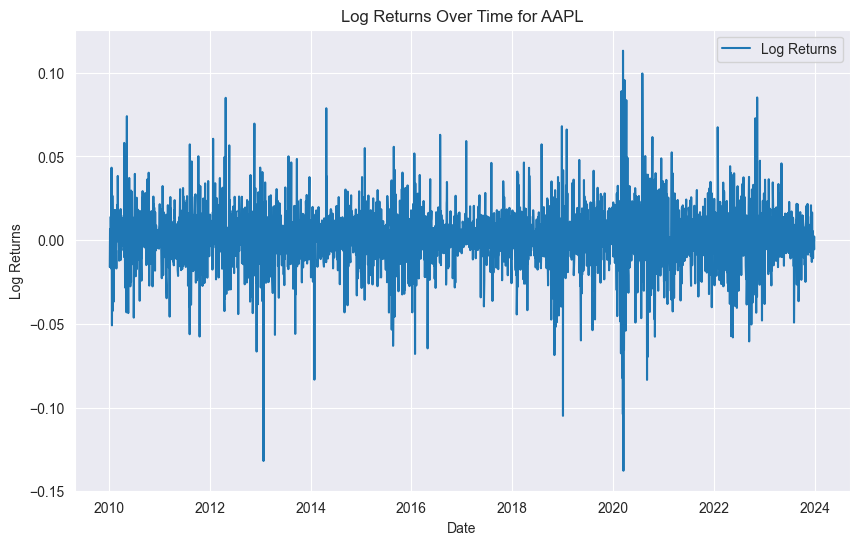

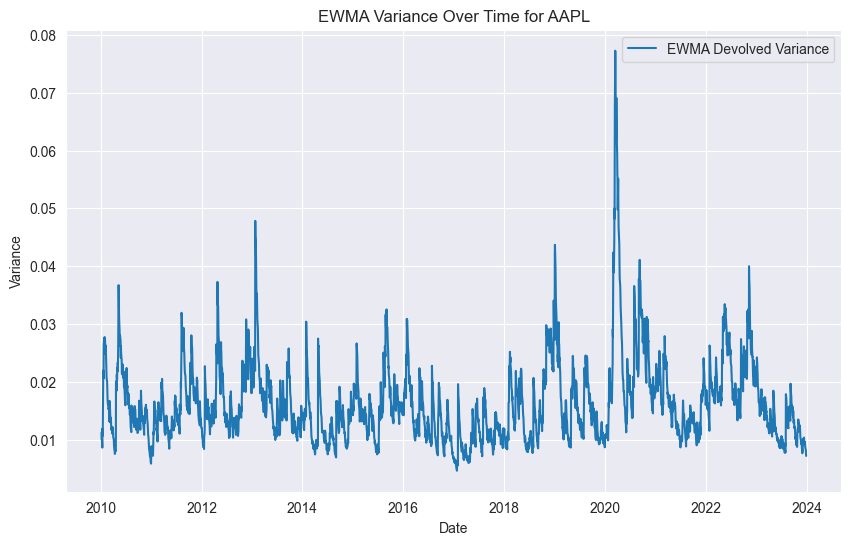

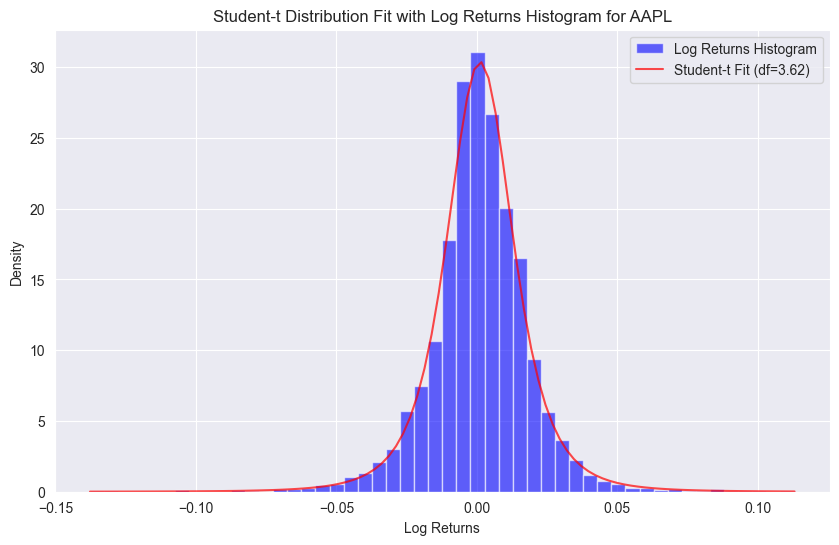

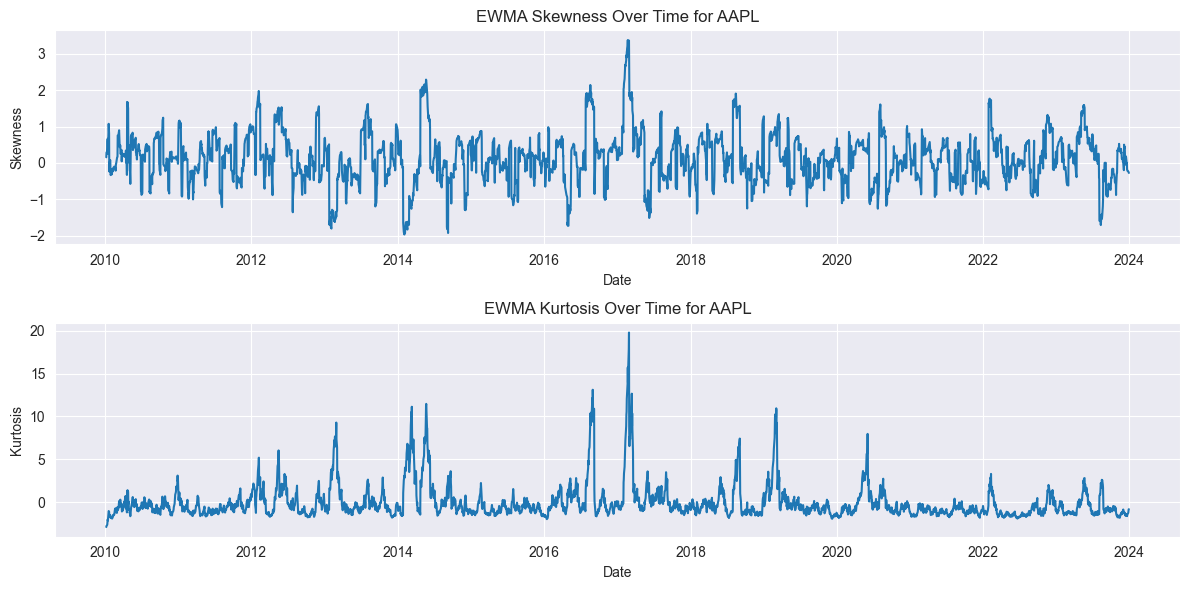

In [87]:
# Main execution for a given stock ticker
ticker = 'AAPL'  # You can change this to any ticker symbol you want to analyze

# Load and process data
data = load_and_process_data(ticker)

# Calculate statistics for the instrument
statistics = calculate_statistics_for_instrument(data, ticker)

# Save the statistics to a CSV file
save_statistics_to_csv(statistics, ticker)

# Visualizations
plot_log_returns_over_time(data, ticker)
plot_ewma_variance_over_time(data, ticker)
plot_student_t_fit_with_histogram(data, ticker)
plot_ewma_skewness_kurtosis_over_time(data, ticker)

